In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

In [2]:
SIZE = 25000
N = 500
K = 250

# shape: (25000,)
inBits = np.random.randint(2, size=(SIZE,))
# shape: (50, 500)
splitBits = np.array(np.split(inBits, SIZE/N))

# Standard-Compliant System

In [286]:
def senc(inBits: np.array) -> np.array:  
    splitBits = np.array(np.split(inBits, SIZE/N))
    
    # creates random bit stream to be sent across channel
    cmplxEnc = lambda k: 0.0586*np.exp(1j*(k%13)*(k%33))

    x1 = np.array([cmplxEnc(k) for k in range(N)]+[0]*K)
    x0 = np.concatenate(([0], x1, [0], np.flip(np.conj(x1))))
    x0 = np.fft.ifft(x0, norm="ortho")
    x0 = x0.real

    xTrain = np.hstack([x0[len(x0)-K:], x0])
    print(xTrain.shape)

    xMat = [xTrain]
    for chunk in splitBits:
        # shape: (500,)
        chunk = np.array([chunk[k]*cmplxEnc(k) for k in range(len(chunk))])

        # shape: (750,)
        chunk = np.concatenate((chunk, np.zeros(K)))

        # shape: (1502,)
        chunk = np.concatenate(([0], chunk, [0], np.flip(np.conj(chunk))))
        chunk = np.fft.ifft(chunk, norm="ortho")
        chunk = chunk.real

        # shape: (1752,)
        chunk = np.hstack([chunk[len(chunk)-K:], chunk])

        xMat.append(chunk)
        
    xMat = np.array(xMat)  
    xMat = xMat.flatten()
    
    """
    In final version, create .wav file here instead of returning
    
    tmp = (np.iinfo(np.int32).max*xMat).astype(np.int32)
    wav.write('encodedInput.wav', 44100, tmp)

    """
    
    return xMat

print(senc(inBits).shape)

(1752,)
(89352,)


In [287]:
x = senc(inBits)
# x = (x/np.linalg.norm(x))
tmp = (np.iinfo(np.int32).max*x).astype(np.int32)
wav.write('encodedInput.wav', 44100, tmp)

(1752,)


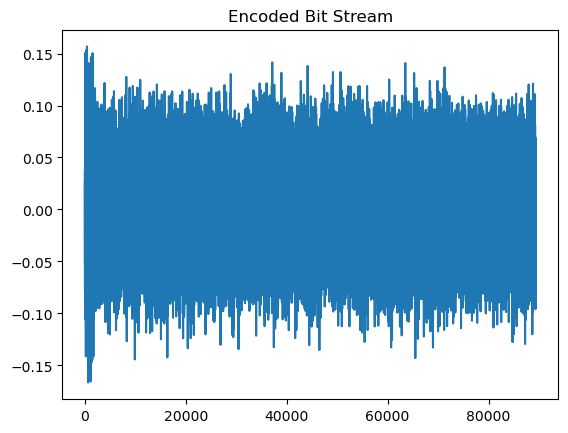

In [288]:
plt.plot(x)
start = 1500
step = 5000
# plt.xlim((start, start+step))
plt.title("Encoded Bit Stream")
plt.show()
plt.close()

### ---------- Send file over CommCloud Here ----------

In [289]:
Fs, Y = wav.read('encodedOutput.wav')
Y = Y/np.iinfo(np.int32).max

Signal Shape: (89332,)


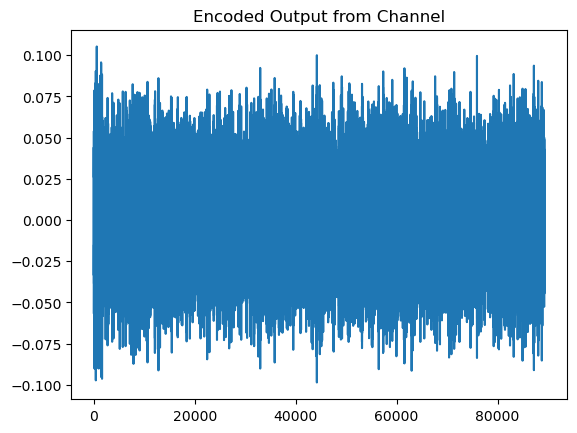

In [290]:
thresh = 0.2*np.max(Y)
startIndex = np.where(np.abs(Y) > thresh)[0][0]
endIndex = (len(Y))-np.where(Y[::-1] > thresh)[0][0]

signal = Y[startIndex:endIndex]

print("Signal Shape:", signal.shape)
plt.plot(signal)
plt.title("Encoded Output from Channel")
plt.show()
plt.close()

(751,)


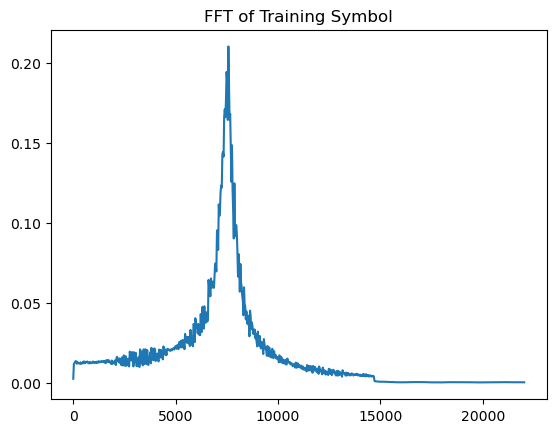

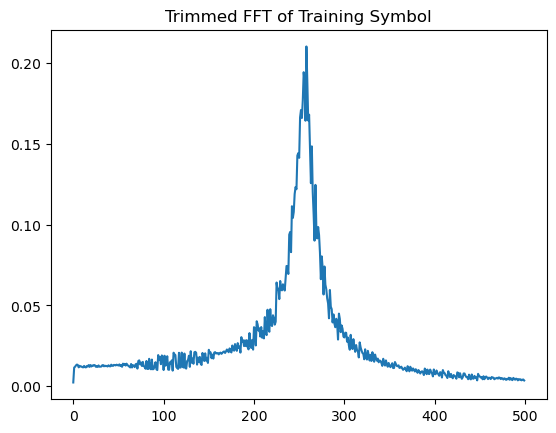

Max occurs at index 258


In [292]:
symbol = signal[:1752]
symbol = symbol[K:]
symbol = np.fft.fft(symbol, norm="ortho")
symbol = np.abs(symbol)
symbol = symbol[:len(symbol)//2]


freq = np.fft.fftfreq(len(symbol)*2, d=1/44100)
freq = freq[:len(freq)//2]

print(symbol.shape)

plt.plot(freq, symbol)
plt.title("FFT of Training Symbol")
plt.show()
plt.close()

# trim zeros/frequencies above 15 kHz
symbol = symbol[:N]

plt.plot(symbol)
plt.title("Trimmed FFT of Training Symbol")
plt.show()
plt.close()

print("Max occurs at index", np.argmax(symbol))

(500,)
Bit Errors (Decoded Signal): 251


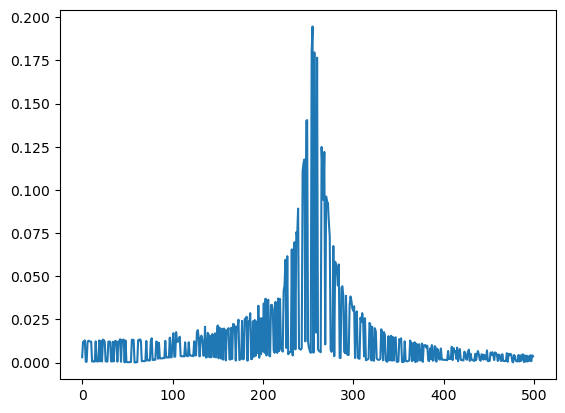

In [293]:
tstSignal = signal[(1752):(1752)*2]
# shape: (1502,)
tstSignal = tstSignal[K:]
tstSignal = np.fft.fft(tstSignal, norm="ortho")
tstSignal = np.abs(tstSignal)
# shape: (751,)
tstSignal = tstSignal[:len(tstSignal)//2]
# shape: (500,)
tstSignal = tstSignal[:N]

outSignal = np.array([(tstSignal[i] > symbol[i]/2) for i in range(len(tstSignal))], dtype=int)

print(tstSignal.shape)
print("Bit Errors (Decoded Signal):", np.count_nonzero(np.logical_xor(inBits[:500], outSignal)))

plt.plot(tstSignal)
plt.show()
plt.close()

In [303]:
def sdec(signal: np.array) -> np.array:
    """
    In final version, read directly from .wav file instead of taking input
    """
    
    symbol = signal[:1752]
    symbol = symbol[K:]
    symbol = np.fft.fft(symbol, norm="ortho")
    symbol = np.abs(symbol)
    symbol = symbol[:len(symbol)//2]
    
    outBits = []
    
    shiftedSignal = signal
    if len(signal) > 51*1752:
        shiftedSignal = signal[:51*1752]
    elif len(signal) < 51*1752:
        shiftedSignal = np.concatenate((signal, np.zeros(np.abs(len(signal) - 51*1752))))

    for chunk in np.reshape(shiftedSignal, (51, 1752))[1:]:
        chunk = chunk[K:]
        chunk = np.fft.fft(chunk)
        chunk = np.abs(chunk)
        chunk = chunk[:len(chunk)//2]
        chunk = chunk[:-1]
        chunk = chunk[:N]

        outBits += [(chunk[i] > symbol[i]/2) for i in range(len(chunk))]
        
    outBits = np.array(outBits)
    return outBits
        
output = sdec(signal)
numErrors = np.count_nonzero(np.logical_xor(inBits, output))
print("Bit Errors:", numErrors)
print("Error Rate:", numErrors/len(inBits))

Bit Errors: 12484
Error Rate: 0.49936


## High Performance System

In [308]:
def greycode(n):
    """
        Parameter: n -> number of bits to be used in grey code
        Returns: list of tuples containing 2^n grey code values
    """
    codeList = []
    for i in range(1 << n):
        val = (i ^ (i >> 1))
        s = bin(val)[2::]
        codeList.append(tuple(map(int, s.zfill(n))))
    return codeList

In [309]:
def enc(inBits: np.array):
    gcBits = 3
    gcNumCodes = 2**gcBits

    cmplxEnc = lambda k: 0.0586*np.exp(1j*(k%13)*(k%33))
    
    # map blocks of three bits to complex numbers
    pskMap = lambda m : np.exp(1j*2*np.pi*m/gcNumCodes)
    # creates complex-valued map of grey-coded bit strings
    mapDict = dict(zip(greycode(gcBits), [pskMap(i) for i in range(gcNumCodes)]))
    
    splitBits = np.array(np.split(inBits, SIZE/N))

    x1 = np.array([cmplxEnc(k) for k in range(N)]+[0]*K)
    x0 = np.concatenate(([0], x1, [0], np.flip(np.conj(x1))))
    x0 = np.fft.ifft(x0, norm="ortho")
    x0 = x0.real

    xTrain = np.hstack([x0[len(x0)-K:], x0])

    xMat = [xTrain]
    for chunk in splitBits:
        chunk = []
        bits = np.reshape(chunk, (-1, gcBits))
        
        for bitGroup in bits:
            chunk.append(mapDict[tuple([(val > 0.5) for val in bitGroup])])
        chunk = np.array(chunk)
        
        chunk = np.array([0.0586*chunk[k] for k in range(len(chunk))])
        chunk = np.concatenate((chunk, np.zeros(K)))
        chunk = np.concatenate(([0], chunk, [0], np.flip(np.conj(chunk))))
        chunk = np.fft.ifft(chunk, norm="ortho")
        chunk = chunk.real
        chunk = np.hstack([chunk[len(chunk)-K:], chunk])

        xMat.append(chunk)
        
    xMat = np.array(xMat)    
    xMat = xMat.flatten()
    
    """
    In final version, create .wav file here instead of returning
    
    tmp = (np.iinfo(np.int32).max*xMat).astype(np.int32)
    wav.write('encodedInput.wav', 44100, tmp)

    """
    
    return xMat

In [310]:
def dec(signal: np.array):
    """
    In final version, read directly from .wav file instead of taking input
    """
    
    gcBits = 3
    gcNumCodes = 2**gcBits
    
    pskMap = lambda m : np.exp(1j*2*np.pi*m/gcNumCodes)
    revMapDict = dict(zip([pskMap(i) for i in range(2**gcBits)], greycode(gcBits)))
    
    outBits = []

    
    shiftedSignal = signal
    if len(signal) > 51*1752:
        shiftedSignal = signal[:51*1752]
    elif len(signal) < 51*1752:
        shiftedSignal = np.concatenate((signal, np.zeros(np.abs(len(signal) - 51*1752))))
        
    xMat = np.reshape(shiftedSignal, (51, 1752))[1:]
    trainSym = xMat[0]

    for chunk in xMat[1:]:
        chunk = chunk[K:]
        chunk = np.fft.fft(chunk)
        chunk = np.abs(chunk)
        chunk = chunk[:len(chunk)//2]
        chunk = chunk[:-1]
        chunk = chunk[:N]
        
        
        outSignal = []

        for val in chunk:
            outSignal.append(
                revMapDict[pskMap(np.argmin(np.abs(np.array(list(revMapDict.keys())) - val)))]
                )

        outSignal = np.array(outSignal).astype(int).flatten()

        outBits += [(outSignal[i] > symbol[i]/2) for i in range(len(chunk))]
        
    outBits = np.array(outBits)
    return outBits

In [314]:
np.count_nonzero(dec(signal).astype(int))

0